<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
%pip install pandas --upgrade
%pip install nltk --upgrade

In [2]:
import os
import re
import time
import warnings


import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier



In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lugma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lugma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lugma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lugma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
warnings.simplefilter(action='ignore')
%matplotlib inline

In [5]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
    
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В наборе данных около 160 тыс. комментариев. Пропуски отсутствуют. Проверим наличие дублей.

In [8]:
df.duplicated().sum()

0

Проверим баланс классов

In [9]:
df['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

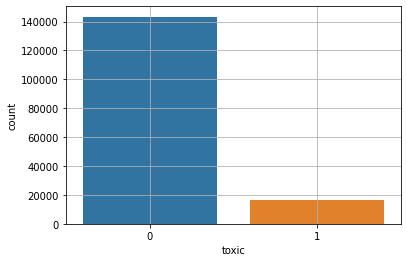

In [10]:
sns.countplot(data=df, x='toxic')
plt.title('')
plt.grid()

Токсичных комментариев существенно меньше, чем позитивных или нейтральных.

Оставим в данных только буквенные символы, приведем все к нижнему регистру

In [11]:
text_column = df['text'].apply(lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).lower().split()))

In [12]:
text_column

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really don t think you understand i came...
Name: text, Length: 159571, dtype: object

Произведем токенизацию текста

In [13]:
token_column = text_column.apply(lambda text: word_tokenize(text))

In [14]:
token_column[:5]

0    [explanation, why, the, edits, made, under, my...
1    [d, aww, he, matches, this, background, colour...
2    [hey, man, i, m, really, not, trying, to, edit...
3    [more, i, can, t, make, any, real, suggestions...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: text, dtype: object

Проведем лемматизацию текста средствами библиотеки nltk

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
lemma_column = token_column.apply(lambda token: ' '.join([lemmatizer.lemmatize(word) for word in token]))

In [17]:
lemma_column[:5]

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

In [18]:
y = df['toxic']

Подготовим обучающий и текстовый выборки

In [19]:
text_train, text_test, y_train, y_test = train_test_split(lemma_column, y, test_size=0.2, random_state=555)

Загрузим список стоп-слов

In [20]:
stop_words = list(stopwords.words('english'))
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

## Обучение

Проверим несколько способов предварительной подготовки корпуса: с использованием мешка слов и параметра TF-IDF, с отсечением стоп-слов и без отсечения, а также с использованием только униграмм и совместно униграмм и биграмм.  
Подготовим соответствующие пайпланы и произведем оценку на модели Логистической Регрессии на кросс-валидации по обучающей выборке.

In [21]:
lgr_model = LogisticRegression(class_weight='balanced')

pipeline_cnt = make_pipeline(CountVectorizer(), lgr_model)
pipeline_cnt_2 = make_pipeline(CountVectorizer(ngram_range=(1,2)), lgr_model)
pipeline_cnt_stop = make_pipeline(CountVectorizer(stop_words=stop_words), lgr_model)
pipeline_cnt_stop_2 = make_pipeline(CountVectorizer(stop_words=stop_words, ngram_range=(1,2)), lgr_model)


pipeline_tfidf = make_pipeline(TfidfVectorizer(), lgr_model)
pipeline_tfidf_2 = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), lgr_model) 
pipeline_tfidf_stop = make_pipeline(TfidfVectorizer(stop_words=stop_words), lgr_model)
pipeline_tfidf_stop_2 = make_pipeline(TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2)), lgr_model)


In [22]:
pipeline_list = [pipeline_cnt, pipeline_cnt_2, pipeline_cnt_stop, pipeline_cnt_stop_2, 
                    pipeline_tfidf, pipeline_tfidf_2, pipeline_tfidf_stop, pipeline_tfidf_stop_2]

In [23]:
for pipeline in pipeline_list:
    print(pipeline.get_params)

    start_time = time.time()
    f1 = cross_val_score(pipeline, X=text_train, y=y_train, cv=3, scoring='f1'). mean()
    end_time = time.time()
    training_time = end_time - start_time

    print(f'F1-score = {round(f1, 2)}, training_time = {round(training_time, 1)}')
    print()

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>
F1-score = 0.76, training_time = 61.0

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>
F1-score = 0.79, training_time = 225.7

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'hi

При использовании CountVectorize добавление биграмм несколько повышает качество модели, однако сильно увеличивает время расчета. Применение стоп-слов несколько ухудшает качество модели, практически не отражаясь на скорости обучения. При использовании TfidfVectorizer качество модели практически не зависит от добавления биграмм и стоп-слов. Метод CountVectorize обеспечивает более высокую метрику качества F1-score, по сравнению с TF-IDF.  
Таким образом, наиболее предпочтитетельная подготовка вектора признаков в данном случае основана на использовании метода мешка слов на основе униграмм и биграмм без использования стоп-слов.

Попробуем также  для выбранного метода подготовки данных, использовать модели классификации с дефолтными параметрами: Дерево Решений, k-ближайших и Логистическую Регрессию со Стохастическим Градиентным Спуском.

In [24]:
# Модель Дерева Решений

pipeline_dtf = make_pipeline(CountVectorizer(ngram_range=(1,2)), DecisionTreeClassifier(random_state=555, 
                                                                                        class_weight='balanced'))
cross_val_score(pipeline_dtf, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.58

In [25]:
# Модель k-Ближайших соседей

pipeline_knn = make_pipeline(CountVectorizer(ngram_range=(1,2)), KNeighborsClassifier())
cross_val_score(pipeline_knn, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.41

In [26]:
#Логистическая Регрессия с SGD

pipeline_sgd = make_pipeline(CountVectorizer(ngram_range=(1,2)), SGDClassifier(random_state=555, 
                                                                                        class_weight='balanced'))
cross_val_score(pipeline_sgd, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.76

Качество моделей Дерево Решений и k-ближайших соседей существенно ниже. Вариант Лостической Регрессии со Стохастическим Градиентным Спуском показывает несколько меньшее значение метрики качества, однако существенно выигрывает во врмени.  
Остановимся на моделях Логистической Регрессии, попробуем настроить гиперпараметры

In [27]:
log_grid = {'logisticregression__C' : np.logspace(-2, 3, 10)}
log_search = GridSearchCV(estimator=pipeline_cnt_2, 
                            param_grid = log_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
log_search.fit(text_train, y_train)
round(log_search.best_score_, 2)

0.7869823266466877

In [28]:
sgd_grid = {'sgdclassifier__loss':['hinge', 'log'],
            'sgdclassifier__learning_rate':['optimal', 'adaptive'],
            'sgdclassifier__eta0':[0.05, 0.1, 0.2, 0.5]}
sgd_search = GridSearchCV(estimator=pipeline_sgd, 
                            param_grid = sgd_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
sgd_search.fit(text_train, y_train)
round(sgd_search.best_score_, 2)

0.78

In [29]:
sgd_search.best_params_

{'sgdclassifier__eta0': 0.2,
 'sgdclassifier__learning_rate': 'adaptive',
 'sgdclassifier__loss': 'hinge'}

Подбор гиперпараметров несколько повысил качество модели SGD. 

Обучим модели Логистической Регрессии на полном наборе обучающих данных и рассчитаем метрику f1 на тестовом наборе.

In [30]:
%%time
log_search.best_estimator_.fit(text_train, y_train)
y_pred = log_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

CPU times: total: 1min 33s
Wall time: 1min


0.789630793401414

In [31]:
%%time
sgd_search.best_estimator_.fit(text_train, y_train)
y_pred = sgd_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

CPU times: total: 29.5 s
Wall time: 28.7 s


0.7843262185409366

Метрика F1 на тестовых данных, соответствует аналогичным показателям на обучающей выборке.

## Выводы

Исходный набор текстовых данных подготовлен для задачи классификации: удалены лишние символы, произведена токенизация и лемматизация текста, сформирована отложенная выборка. На модели логистической регрессии проверено несколько вариантов подготовки векторов признаков из исходного корпуса: с использованием мешка слов и TF-IDF, со стоп-словами и без, а также с разделением на униграммы и биграммы и только на униграммы. Выбран способ подготовки с использованием CountVectorizer, без стоп-слов и на основе униграмм и биграмм. 
Проверено несколько других методов классификации: Деревья Решений, k-ближайших соседей и Логистическая регрессия со стохастическим Градиентным Спуском. Наилучшее значение метрики качества F1 на обучающей выборке на кросс-валидации получено на Логистической Регрессии, применение метода SGD несколько снижает качество, однако дает выигрыш в скорости расчета. Выбранные модели протестированы на отложенной выборке, метрика f1 составила 0,78 - 0,79, что примерно соответствует качеству на обучающей выборке.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны